In [1]:
!git clone https://github.com/quentgar/dip-inpainting-registration
!mv dip-inpainting-registration/* ./

Cloning into 'dip-inpainting-registration'...
remote: Enumerating objects: 1452, done.
remote: Counting objects: 100% (891/891), done.
remote: Compressing objects: 100% (594/594), done.
remote: Total 1452 (delta 435), reused 535 (delta 252), pack-reused 561
Receiving objects: 100% (1452/1452), 95.98 MiB | 30.11 MiB/s, done.
Resolving deltas: 100% (688/688), done.


In [2]:
pip install voxelmorph

     |████████████████████████████████| 75 kB 2.4 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 


# Import 

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

from src.utils import *
from src.hourglass_network import *
from src.Nathan import layers
from src.Nathan.hourglass_roto import *

import torch
import torch.optim

import numpy as np

from voxelmorph.torch.layers import SpatialTransformer

import time
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

from skimage.measure import compare_psnr

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
dim_div_by = 64

# Choose figure

In [4]:
img_path = 'mydata/video/car_window/07.jpg'
mask_path = 'mydata/video/car_window/mask/mask_08.jpg'
#mask_path = 'mask_01_2.jpg'
img_path2 = 'mydata/video/car_window/08.jpg'

In [5]:
img_np = format_image(img_path, dim_div_by)
img_np2 = format_image(img_path2, dim_div_by)
img_mask_np = format_image(mask_path, dim_div_by)
size = img_np.shape[1:]

### Visualize

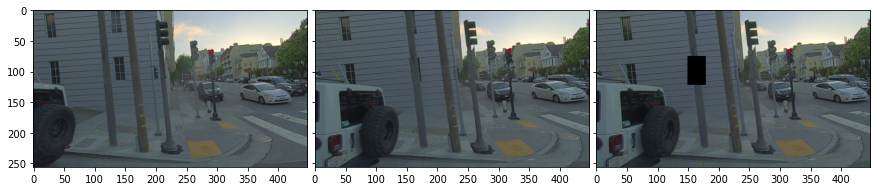

In [6]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [img_np, img_np2, img_mask_np*img_np2]):
    ax.imshow(im.transpose(1,2,0))

plt.show()

# Setup

In [11]:
INPUT = 'noise'
input_depth = 32
LR_inp = 0.001 
LR_rec = 0.1
num_iter = 2000
show_every = 50
figsize = 8
reg_noise_std = 0.03

net_rec = build_hourglass(input_depth, 2,
                      num_channels_down = 128,
                      num_channels_up = 128, 
                      num_channels_skip = 16,
                      filter_size_up = 5,filter_size_down = 5,
                      num_scales = 5, 
                      up_samp_mode='nearest', need_sigmoid=False).type(dtype)

net_inp = build_hourglass(input_depth, img_np.shape[0],
                      num_channels_down = 128,
                      num_channels_up = 128, 
                      num_channels_skip = 4,
                      filter_size_up = 5,filter_size_down = 5,
                      num_scales = 5, 
                      up_samp_mode='nearest').type(dtype)                     

net_rec = net_rec.type(dtype)
net_inp = net_inp.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
print(net_input.shape)

torch.Size([1, 32, 256, 448])


In [12]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net_rec.parameters())
print ('Number of params rec: %d' % s)

s  = sum(np.prod(list(p.size())) for p in net_inp.parameters())
print ('Number of params inp: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(torch.FloatTensor)
mask_var = np_to_torch(img_mask_np).type(dtype)
img_var2 = np_to_torch(img_np2).type(dtype)
print(img_var.shape)
print(img_np.shape)

Number of params rec: 6194578
Number of params inp: 5994727
torch.Size([1, 3, 256, 448])
(3, 256, 448)


# Main loop

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


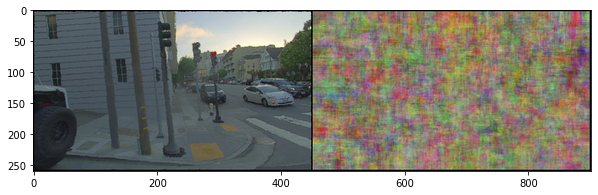

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


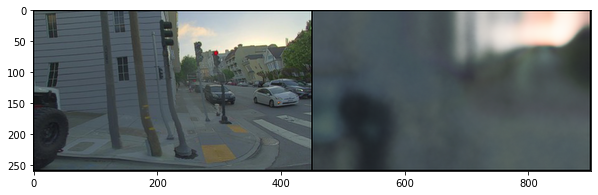

KeyboardInterrupt: ignored

In [13]:
start_time = time.time()

i = 0
l1 = 1
l2 = 3
#l2_lambda = 0.001
list_loss = []
list_psnr = []
list_iter = []
best_loss = 10
best_psnr = 0
best_iter = 0
best_out = None
best_flow = None
last_net_inp = None
last_net_rec = None
psrn_last = 0
first_net = [x.detach().cpu() for x in net_inp.parameters()]
pic = True

transformer = SpatialTransformer(size)

def closure():
    
    global i, list_loss, list_iter, list_psnr, best_psnr, best_iter, best_out, best_loss, best_flow, psrn_last, last_net_inp, last_net_rec, first_net, pic

    net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        

    out = net_inp(net_input).type(torch.FloatTensor)
    flow = net_rec(net_input).type(torch.FloatTensor)

    #Loss1
    #out_trans = transformer(out, flow).to('cuda:0')
  
    #total_loss = l2*mse(out.to('cuda:0') * mask_var.to('cuda:0'), img_var2.to('cuda:0') * mask_var.to('cuda:0')) + l1*mse(out_trans.to('cuda:0'), img_var.to('cuda:0'))

    #Loss2
    out_trans = transformer(img_var.to('cpu'), flow).to('cuda:0')
  
    total_loss = l2*mse(out.to('cuda:0') * mask_var.to('cuda:0'), img_var2.to('cuda:0') * mask_var.to('cuda:0')) + l1*mse(out.to('cuda:0'), out_trans.to('cuda:0'))

    total_loss.backward()

    psrn_gt = compare_psnr(img_np2, out.detach().cpu().numpy()[0])

    if psrn_gt > best_psnr:
      best_loss = total_loss.item()
      best_psnr = psrn_gt
      best_iter = i
      best_out = out
      best_flow = flow

        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out_trans)
        out = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), np.clip(out, 0, 1)], factor=figsize, nrow=2)
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')

        list_loss.append(total_loss.item())
        list_iter.append(i)
        psnr = compare_psnr(img_np2, out_np) 
        list_psnr.append(psnr)


    # Backtracking
    if i % show_every:
        if psrn_gt - psrn_last < -3: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net_inp, net_inp.parameters()):
                net_param.data.copy_(new_param.cuda())

            i += 1

            return total_loss*0
        else:
            last_net_inp = [x.detach().cpu() for x in net_inp.parameters()]
            psrn_last = psrn_gt
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p1 = get_params(net_inp)
p2 = get_params(net_rec)
optimize_joint(p1, p2, closure, LR_inp, LR_rec, num_iter, ind_iter=1)

end_time = time.time()

# Vue résultats

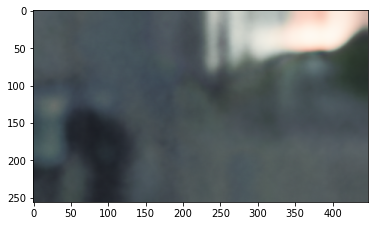

In [14]:
best_out_np = torch_to_np(best_out)
plt.imshow(best_out_np.transpose(1,2,0))

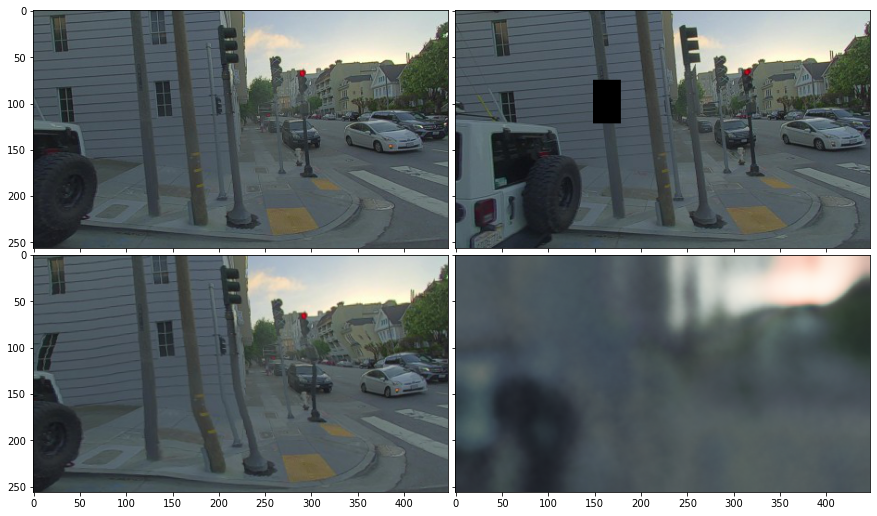

In [15]:
best_out_np = torch_to_np(best_out)

flow2 = net_rec(net_input).to('cpu')
out2 = net_inp(net_input).to('cpu')
transformer = SpatialTransformer(size)
out_trans2 = transformer(img_var, flow2).to('cuda:0')
out_np2 = torch_to_np(out2)
out_trans2 = torch_to_np(out_trans2)

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [img_np, img_mask_np*img_np2, out_trans2, out_np2]):
    ax.imshow(im.transpose(1,2,0))

plt.show()

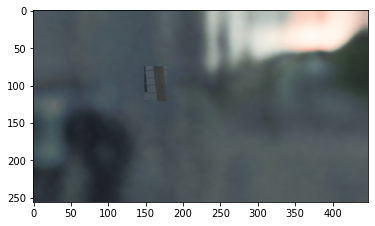

In [16]:
#Prendre le meilleur des deux sorties de réseaux
img_recollée = out_np2 * img_mask_np + out_trans2 * (1 - img_mask_np)
plt.imshow(img_recollée.transpose(1,2,0))

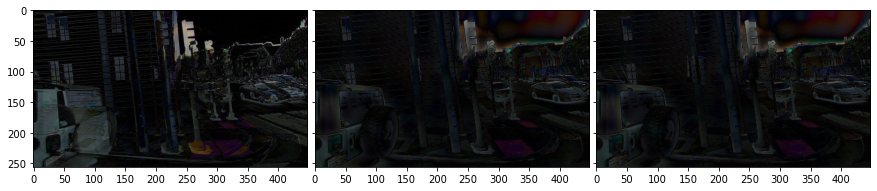

In [17]:
#diff = abs(best_out_np - img_np)

diff2 = abs(img_np - img_np2)

diff3 = abs(img_np2 - torch_to_np(net_inp(net_input)))

diff4 = abs(img_np2 -(out_np2 * img_mask_np + out_trans2 * (1 - img_mask_np)))

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [diff2, diff3, diff4]):
    ax.imshow(im.transpose(1,2,0))

plt.show()

In [18]:
time_ex = end_time - start_time
minutes = time_ex // 60
secondes = time_ex % 60
print( '%s minutes %s secondes' % (minutes,secondes))

NameError: ignored

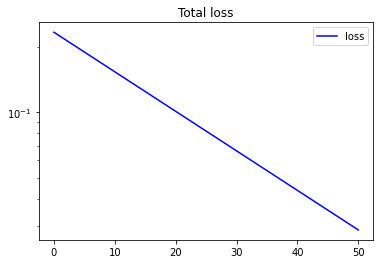

In [19]:
  plt.figure()

  plt.semilogy(list_iter, list_loss, 'b',label='loss')
  plt.title('Total loss')
  plt.legend()

  plt.show()

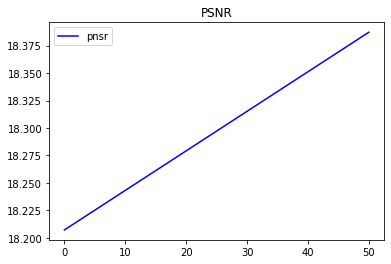

In [20]:
  plt.figure()

  plt.plot(list_iter, list_psnr, 'b',label='pnsr')
  plt.title('PSNR')
  plt.legend()

  plt.show()

# Champ de vecteur

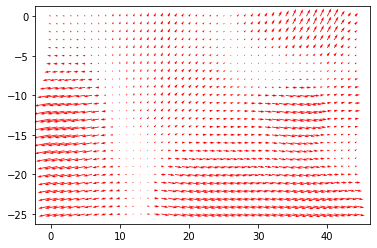

In [21]:
Ut = flow2[:,1,:,:]
Vt = flow2[:,0,:,:]
#print(Ut.shape)
Ut = torch_to_np(Ut)
Vt = torch_to_np(Vt)
#print(Ut.shape)
echant_div = 10
U = Ut[0:size[0]:echant_div, 0:size[1]:echant_div]
V = Vt[0:size[0]:echant_div, 0:size[1]:echant_div]
#print(U.shape)
#print(V.shape)

X, Y = np.meshgrid(np.arange(0, U.shape[1], 1), np.arange(0, U.shape[0], 1))
#print(X.shape)
#print(Y.shape)

x_shape = X.shape

plt.quiver(X,-Y,-U,V, units='xy' ,scale=X.mean()/2, color='red')
plt.show()

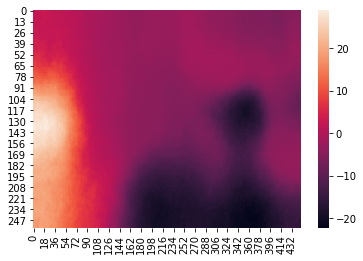

In [22]:
ax = sns.heatmap(Ut)
plt.show()

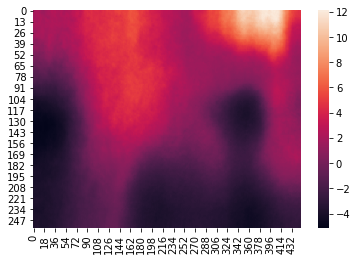

In [23]:
ax = sns.heatmap(Vt)
plt.show()

(256, 448)
(3, 256, 448)


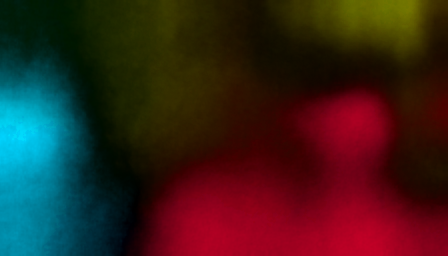

In [24]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

print(Ut.shape)
# Use Hue, Saturation, Value colour model 
hsv = np.zeros(img_np.shape, dtype=np.uint8)
hsv[1, ...] = 255

mag, ang = cv2.cartToPolar(-Ut, Vt)
hsv[0, ...] = ang * 180 / np.pi / 2
hsv[2, ...] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
print(hsv.shape)
bgr = cv2.cvtColor(hsv.transpose(1,2,0), cv2.COLOR_HSV2BGR)
cv2_imshow(bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()